## Project 3 - Variable Selection for Regression (Non Linear Programming)
---
**Group 22 - Anudeep Kumar Akkana (aa92799),Snehal Naravane (sn27429), Prathmesh Savale (ps33296), Vishwak Venkatesh (vv8257)**


In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
# setting time limit for gurobi
timeLimit = 7200

## Importing train and test sets

In [3]:
# import train and test sets
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

In [4]:
train.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


## MIQP (Direct Variable Selection)

In [5]:
M = 15 # Setting Big M value as 15
n = len(train)
m = train.shape[1] - 1 # Number of features

Let's create 10 cross-validation folds. For each value of k, we'll train optimization models on 9 folds & test it on the remaining fold. Thus for each value of k, we'll train 10 models.

We'll repeat this for each value of k from 5 to 50 resulting in 100 models trained.

The value of k with the least MSE will be selected

In [6]:
# Cross validation
folds = []
indices = np.array(train.index)
for i in range(10):
    new_fold = list(np.random.choice(indices, int(n/10), replace = False))
    folds.append(new_fold)
    indices = np.delete(indices, np.argwhere(np.isin(indices,new_fold)))

In [7]:
folds = np.array(folds)

In [8]:
k_list = [i*5 for i in range(1,11)]
mse = []
for k in k_list:
    
    ind_mse = []
    for val_test_ind in folds:

        val_train_ind = np.delete(folds, np.argwhere(np.isin(folds.flatten(),val_test_ind)))

        X = np.ones((len(val_train_ind), m+1))
        X[:,1:] = np.array(train.iloc[val_train_ind].drop(['y'], axis = 1))

        # Quadratic term
        Q = np.zeros((2*m + 1, 2*m + 1))
        Q[:(m+1),:(m+1)] = np.transpose(X) @ X

        # linear term
        c = np.zeros((2*m + 1))
        c[:(m+1)] = (-2 * np.transpose(np.array(train.iloc[val_train_ind]['y']))) @ X

        # Constraints
        # 2*m big M constraints + 1 k constraint
        A = np.zeros((2*m+1, 2*m+1)) # m+1 betas & m z variables
        A[0:m,1:m+1] = np.identity(m)
        A[0:m,m+1:2*m+1] = np.identity(m) * M
        A[m:2*m,1:m+1] = np.identity(m)
        A[m:2*m,m+1:2*m+1] = np.identity(m) * (-M)
        A[2*m,m+1:2*m+1] = 1

        # RHS
        rhs = np.zeros((2*m+1))
        rhs[2*m] = k

        # Direction of constraints
        sense = ['>'] * m + ['<'] * m + ['<']

        # Variable types - m+1 betas can take any values & m z should be binary
        vtypes = ['C'] * (m+1) + ['B'] * m
        
        # Lower bounds - lb for coefficients is -M & 0 for the z variables
        lb = np.array([-M] * (m+1) + [0] * m)

        # Solve the problem
        op_mod = gp.Model()
        op_mod_x = op_mod.addMVar(2*m + 1, vtype = vtypes, lb = lb)
        op_mod_con = op_mod.addMConstr(A, op_mod_x, sense, rhs)
        op_mod.setMObjective(Q,c,0,sense=gp.GRB.MINIMIZE) # Having Q in the quadratic terms & c for linear terms

        op_mod.Params.OutputFlag = 0 
        op_mod.Params.TimeLimit = timeLimit
        op_mod.optimize()

        x_val = np.hstack((np.ones((len(val_test_ind),1)), train.iloc[val_test_ind].drop(['y'], axis = 1)))
        y_val_pred = x_val @ op_mod_x.x[0:m+1]
        y_val = train.iloc[val_test_ind]['y']
        ind_mse.append(mean_squared_error(y_val, y_val_pred))
        
    print('MIQP with', k, 'variables done')
    mse.append(np.mean(ind_mse))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19
MIQP with 5 variables done
MIQP with 10 variables done
MIQP with 15 variables done
MIQP with 20 variables done
MIQP with 25 variables done
MIQP with 30 variables done
MIQP with 35 variables done
MIQP with 40 variables done
MIQP with 45 variables done
MIQP with 50 variables done


In [9]:
mse_df = pd.DataFrame(mse, index = k_list)
mse_df.to_csv('MSE.csv')

In [16]:
mse_df = pd.read_csv('MSE.csv', index_col = ['Unnamed: 0'])

<Figure size 1440x576 with 0 Axes>

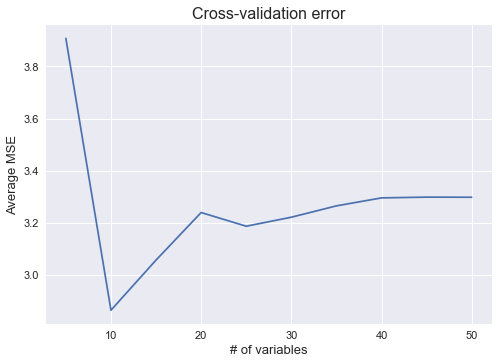

In [22]:
plt.figure(3, figsize=(20, 8))
mse_df.plot(legend = None)
plt.xlabel('# of variables', fontsize = 13)
plt.ylabel('Average MSE', fontsize = 13)
plt.title('Cross-validation error', fontdict={'fontsize': 16})
plt.xticks(fontsize= 11)
plt.yticks(fontsize= 11)
plt.show()

**k = 10 has the least cross-validation error**

In [8]:
# Now fit MIQP on entire training set with k = 10
k = 10

In [9]:
# Create the X term
X = np.ones((n, m+1))
X[:,1:] = np.array(train.drop(['y'], axis = 1))
X

array([[ 1.00000000e+00, -1.53541286e+00,  7.18887717e-01, ...,
        -4.71045042e-01, -1.13978107e+00, -2.60772742e-01],
       [ 1.00000000e+00, -1.73460938e+00,  5.51981259e-01, ...,
        -2.42564880e-01, -1.82662085e-03,  1.18745316e+00],
       [ 1.00000000e+00,  9.72566647e-02,  1.07634348e-01, ...,
        -7.51230919e-01,  1.45060937e+00,  2.90593419e-01],
       ...,
       [ 1.00000000e+00,  9.12367152e-02,  4.73697596e-01, ...,
        -8.41853603e-02, -2.00142679e-01,  8.40785925e-01],
       [ 1.00000000e+00, -1.40700336e+00,  5.10885944e-01, ...,
        -5.22506923e-02,  5.43761518e-01,  2.74006244e-01],
       [ 1.00000000e+00, -1.95950543e+00,  2.71732927e-01, ...,
         2.05276206e+00,  3.35630224e-02, -1.19848557e+00]])

In [10]:
# Quadratic term
Q = np.zeros((2*m + 1, 2*m + 1))
Q[:(m+1),:(m+1)] = np.transpose(X) @ X
Q

array([[250.        , -21.82060874,   6.6181744 , ...,   0.        ,
          0.        ,   0.        ],
       [-21.82060874, 294.48645592, -23.11583679, ...,   0.        ,
          0.        ,   0.        ],
       [  6.6181744 , -23.11583679, 205.70270984, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [11]:
# linear term
c = np.zeros((2*m + 1))
c[:(m+1)] = (-2 * np.transpose(np.array(train['y']))) @ X
c

array([-638.11624311,  343.36934241,   54.54405608,  274.0074376 ,
        546.98965887,  303.53964959, -158.00065103,  573.07981675,
        237.62019633, 1799.38142127, -186.14261381,  314.54531445,
        292.98329336,  123.95195574,  548.66969632,  424.12023934,
       1155.83230325, -167.61818145,  456.43296426, -176.0475388 ,
       -247.23531054, -454.20054062,  795.84357421,  446.01483599,
       -887.17851852, -134.34311241, 1102.16230976, -299.69285586,
       -245.9323427 , -827.29465903,  165.38942932,  153.37851856,
        171.77012239,  644.1361135 , -151.27649651, -866.9939987 ,
        122.55748068,  397.1161159 ,  -99.67517163,  167.08652963,
        152.17696572,  -92.06136727, -199.81913824,   50.5061756 ,
       -444.32648337, -810.99631196,  200.57475569,  303.48897075,
        253.66344732,  276.62139926,  -38.93151649,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.     

In [12]:
# Constraints

# 2*m big M constraints + 1 k constraint
A = np.zeros((2*m+1, 2*m+1)) # m+1 betas & m z variables

# No big M constraint for beta 0
A[0:m,1:m+1] = np.identity(m)
A[0:m,m+1:2*m+1] = np.identity(m) * M
A[m:2*m,1:m+1] = np.identity(m)
A[m:2*m,m+1:2*m+1] = np.identity(m) * (-M)
A[2*m,m+1:2*m+1] = 1
A

array([[  0.,   1.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  -0., -15.,  -0.],
       [  0.,   0.,   0., ...,  -0.,  -0., -15.],
       [  0.,   0.,   0., ...,   1.,   1.,   1.]])

In [13]:
# RHS
rhs = np.zeros((2*m+1))
rhs[2*m] = k
rhs

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.])

In [14]:
# Direction of constraints
sense = ['>'] * m + ['<'] * m + ['<']

In [15]:
# Variable types - m+1 betas can take any values & m z should be binary
vtypes = ['C'] * (m+1) + ['B'] * m

In [16]:
# Lower bounds - lb for coefficients is -M & 0 for the z variables
lb = np.array([-M] * (m+1) + [0] * m)

In [17]:
# Solve the problem
op_mod = gp.Model()
op_mod_x = op_mod.addMVar(2*m + 1, vtype = vtypes, lb = lb)
op_mod_con = op_mod.addMConstr(A, op_mod_x, sense, rhs)
op_mod.setMObjective(Q,c,0,sense=gp.GRB.MINIMIZE) # Having Q in the quadratic terms & c for linear terms 
op_mod.Params.OutputFlag = 0 

op_mod.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-21


In [18]:
miqp_coefs = op_mod_x.x[0:m+1]

In [19]:
# Look at the non-zero MIQP coefficients
miqp_coef_df = pd.DataFrame(miqp_coefs, index = train.columns, columns = ['Coefficients'])
miqp_coef_df.rename(index = {'y':'Intercept'}, inplace = True)
miqp_coef_df.loc[miqp_coef_df['Coefficients']!=0]

,Coefficients
Intercept,0.972524
X9,-2.308207
X15,-0.518326
X16,-0.204162
X23,-1.559143
X24,0.866973
X26,-1.311919
X34,0.408165
X45,1.781475
X47,0.887383


In [20]:
# Sorted by coefficients (excluding intercept) & filtering out features not selected in model
miqp_coef_df.iloc[1:].loc[miqp_coef_df['Coefficients'] != 0].sort_values(by = 'Coefficients')

,Coefficients
X9,-2.308207
X23,-1.559143
X26,-1.311919
X15,-0.518326
X48,-0.282292
X16,-0.204162
X34,0.408165
X24,0.866973
X47,0.887383
X45,1.781475


A unit change in X9 has most absolute change on Y by decreasing it by 2.31 units. A unit change in X45 increases Y by 1.78 units

In [21]:
x_test = np.hstack((np.ones((len(test),1)), np.array(test.drop(['y'], axis = 1))))
y_test_pred_miqp = x_test @ op_mod_x.x[0:m+1]

In [22]:
print('Test MSE: ', mean_squared_error(test['y'], y_test_pred_miqp))

Test MSE:  2.336543964552524


## Lasso Regression (Indirect Variable Selection)

In [23]:
X_train = train.drop(['y'], axis = 1)
y_train = train['y']
X_test = test.drop(['y'], axis = 1)
y_test = test['y']

In [24]:
lasso_cv = LassoCV(cv = 10, random_state = 1, normalize = True)
lasso_cv.fit(X_train, y_train)

LassoCV(cv=10, normalize=True, random_state=1)

In [25]:
# Penalization obtained from CV
lasso_cv.alpha_

0.0057453437864455085

Text(0.5, 1.0, 'CV log MSE vs. lambda')

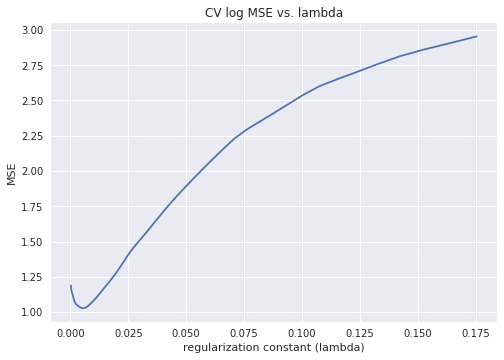

In [68]:
# checking the MSE wrt different values of alpha(or lambda regularization parameter)
plt.plot(lasso_cv.alphas_, np.log(pd.DataFrame(lasso_cv.mse_path_).mean(axis=1)))
plt.xlabel('regularization constant (lambda)')
plt.ylabel('MSE')
plt.title('CV log MSE vs. lambda')

In [69]:
lasso = Lasso(alpha = lasso_cv.alpha_, normalize = True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.0057453437864455085, normalize=True)

In [70]:
lasso_coefs = [lasso.intercept_] + list(lasso.coef_)

In [71]:
# Look at the LASSO coefficients
lasso_coef_df = pd.DataFrame({'Coefficients': lasso_coefs}, index = train.columns)
lasso_coef_df.rename(index = {'y':'Intercept'}, inplace = True)
lasso_coef_df.loc[lasso_coef_df['Coefficients']!=0]

,Coefficients
Intercept,1.006196
X9,-2.115615
X11,-0.060431
X15,-0.416745
X16,-0.181553
X22,-0.197102
X23,-1.365528
X24,0.735100
X26,-1.300186
X29,0.063903


## Comparing MIQP and Lasso

In [72]:
# Compare coefficients between MIQP & LASSO
coefs = pd.DataFrame({'MIQP':miqp_coefs, 'LASSO':lasso_coefs}, index = train.columns)
coefs.rename(index = {'y':'Intercept'}, inplace = True)
coefs

,MIQP,LASSO
Intercept,0.972524,1.006196
X1,0.000000,-0.000000
X2,0.000000,-0.000000
X3,0.000000,0.000000
X4,0.000000,0.000000
X5,0.000000,-0.000000
X6,0.000000,0.000000
X7,0.000000,-0.000000
X8,0.000000,-0.000000
X9,-2.308207,-2.115615


In [73]:
print('Number of features driven to zero: ', len(coefs[coefs['LASSO'] == 0]))
print('Number of features not driven to zero: ', len(coefs[coefs['LASSO'] != 0])-1) #we do a -1 here to exclude the intercept

Number of features driven to zero:  32
Number of features not driven to zero:  18


In [31]:
# Predict on test set
y_test_pred_lasso = lasso.predict(X_test)

In [32]:
# Print errors
print('Mean squared error on test set: %.5f' % (mean_squared_error(y_test, y_test_pred_lasso)))

Mean squared error on test set: 2.35971


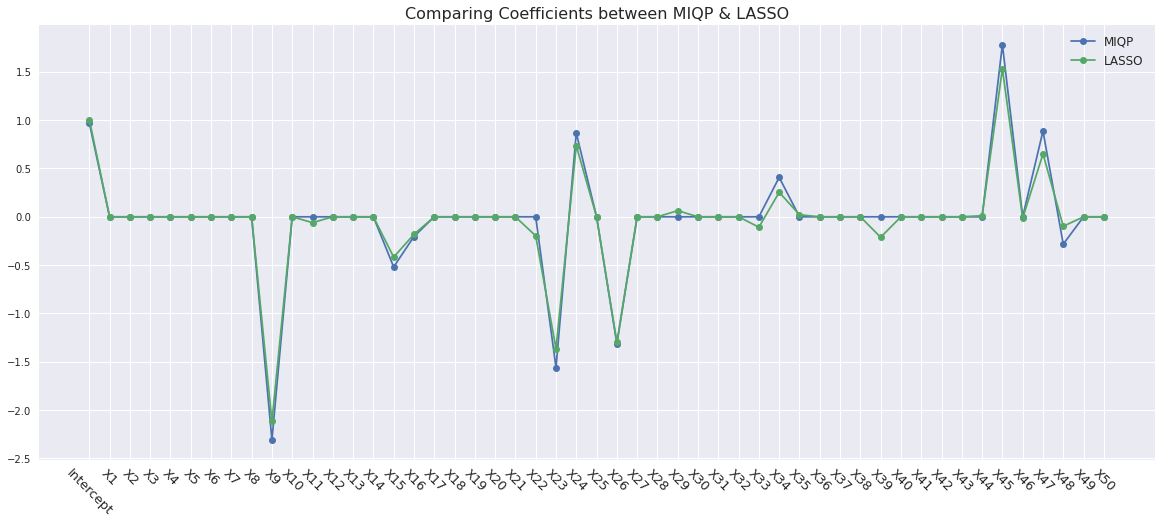

In [33]:
# Comparison of regression coefficients between MIQP & LASSO
plt.figure(3, figsize=(20, 8))
plt.plot(coefs.index, coefs['MIQP'], label = 'MIQP', marker='o')
plt.plot(coefs.index, coefs['LASSO'], label = 'LASSO', marker='o')
plt.xticks(rotation = -45, fontsize= 13)
plt.legend(loc='best',  fontsize=12)
plt.title('Comparing Coefficients between MIQP & LASSO', fontdict={'fontsize': 16})
plt.show()

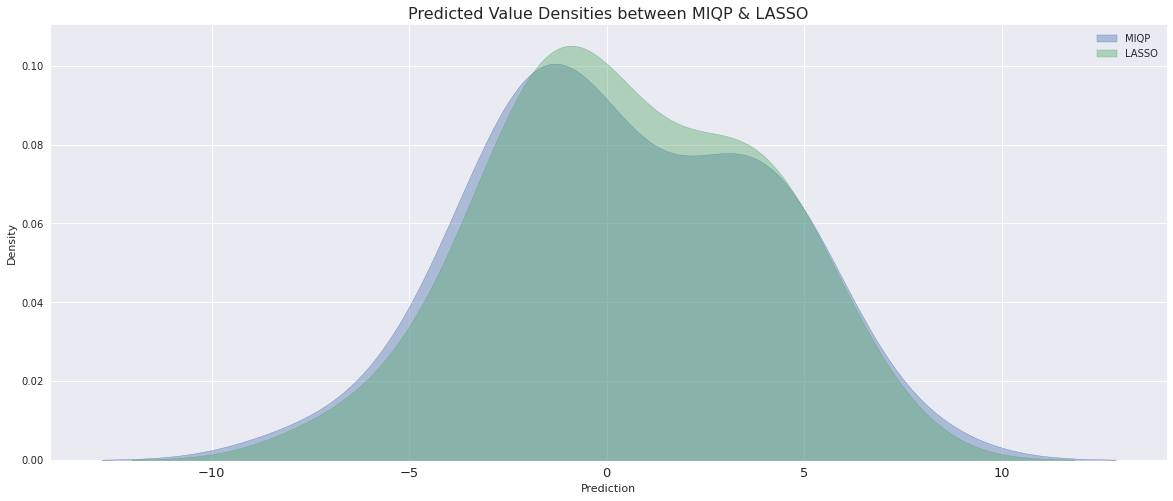

In [34]:
# Comparing predictions between MIQP & LASSO
plt.figure(3, figsize=(20, 8))
sns.kdeplot(y_test_pred_miqp, alpha = 0.4, fill = True, label='MIQP', legend=True)
sns.kdeplot(y_test_pred_lasso, alpha = 0.4, fill = True, label='LASSO', legend=True)
plt.legend()
plt.xlabel('Prediction')
plt.title('Predicted Value Densities between MIQP & LASSO', fontdict={'fontsize': 16})
plt.xticks(fontsize= 13)
plt.show()